In [114]:
import pandas as pd
import numpy as np
from datetime import date,datetime
import requests
import json
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
import psycopg2
from config import config
import gspread
from gspread_dataframe import set_with_dataframe
from google.oauth2.service_account import Credentials
# from pydrive.auth import GoogleAuth
# from pydrive.drive import GoogleDrive
import scipy

# Import Data

In [2]:
param_database = config('postgresql')

In [3]:
def init_connection():
    conn = psycopg2.connect(**param_database)
    cur = conn.cursor()
    return conn, cur

In [4]:
def query_to_df(conn,cur,query) -> pd.DataFrame:
    cur.execute(query)
    tuples_list = cur.fetchall()
    colnames = [desc[0] for desc in cur.description]
    df = pd.DataFrame(tuples_list,columns=colnames)
    return df

In [183]:
conn, cur = init_connection()

In [185]:
btc_daily = query_to_df(conn,cur,"""
    SELECT * FROM btc_daily
    WHERE date <= date'2023-12-31';
    """)

In [186]:
btc_monthly = query_to_df(conn,cur,"""
    SELECT * FROM btc_monthly
    WHERE monthdate <= date'2023-12-31';
    """)

In [187]:
cpi_monthly = query_to_df(conn,cur,"""
    SELECT * FROM cpi_monthly
    WHERE monthdate <= date'2023-12-31';
    """)

In [188]:
gold_daily = query_to_df(conn,cur,"""
    SELECT * FROM gold_daily
    WHERE date <= date'2023-12-31';
    """)

In [189]:
gold_monthly = query_to_df(conn,cur,"""
    SELECT * FROM gold_monthly
    WHERE monthdate <= date'2023-12-31';
    """)

In [190]:
ihsg_daily = query_to_df(conn,cur,"""
    SELECT * FROM ihsg_daily
    WHERE date <= date'2023-12-31';
    """)

In [191]:
ihsg_monthly = query_to_df(conn,cur,"""
    SELECT * FROM ihsg_monthly
    WHERE monthdate <= date'2023-12-31';
    """)

In [192]:
usd_daily = query_to_df(conn,cur,"""
    SELECT * FROM usd_daily
    WHERE date <= date'2023-12-31';
    """)

In [193]:
usd_monthly = query_to_df(conn,cur,"""
    SELECT * FROM usd_monthly
    WHERE monthdate <= date'2023-12-31';
    """)

In [194]:
monthly_changes = query_to_df(conn,cur,"""
    SELECT
        monthdate,
        cast(cpi_mom_change as decimal) cpi_mom_change,
        cast(btc_mom_change as decimal) btc_mom_change,
        ihsg_mom_change,
        usd_mom_change,
        cast(gold_mom_change as decimal) gold_mom_change
    FROM monthly_changes
    WHERE monthdate <= date'2023-12-31';
    """)

In [195]:
combined_monthly = query_to_df(conn,cur,"""
    select 
        c.cpi,
        b.avg_closing as btc,
        u.avg_closing as usd,
        i.avg_closing as ihsg,
        g.avg_closing as gold
    from cpi_monthly c
    left join btc_monthly b
    on c.monthdate = b.monthdate
    left join usd_monthly u
    on c.monthdate = u.monthdate
    left join ihsg_monthly i
    on c.monthdate = i.monthdate
    left join gold_monthly g
    on c.monthdate = g.monthdate
    WHERE c.monthdate <= date'2023-12-31'; 
    """)

In [196]:
yearly_changes = query_to_df(conn,cur,"""
    SELECT * FROM yearly_changes
    WHERE yeardate <= date'2023-01-01';
    """)

In [197]:
cur.close()
conn.close()

# Export Dataframes to Google Sheets

In [18]:
df_dict = {
    'btc_daily':btc_daily,
    'btc_monthly':btc_monthly,
    'cpi_monthly':cpi_monthly,
    'gold_daily':gold_daily,
    'gold_monthly':gold_monthly,
    'ihsg_daily':ihsg_daily,
    'ihsg_monthly':ihsg_monthly,
    'usd_daily':usd_daily,
    'usd_monthly':usd_monthly,
    'monthly_changes':monthly_changes,
    'yearly_changes':yearly_changes
}

In [19]:
scopes = ['https://www.googleapis.com/auth/spreadsheets',
          'https://www.googleapis.com/auth/drive']

credentials = Credentials.from_service_account_file('four-assets-project-b8195ded184f.json', scopes=scopes)

gc = gspread.authorize(credentials)

# gauth = GoogleAuth()
# drive = GoogleDrive(gauth)

# open a google sheet
gs = gc.open_by_key('1-_CTf0vEsV-FQTJVVsqSVFykAls0_0ZND9redN8qIS0')
# select a work sheet from its name
worksheet1 = gs.worksheet('btc_daily')

In [20]:
def export_to_gsheet(sheet_name,dataframe):
    ws = gs.worksheet(sheet_name)
    ws.clear()
    set_with_dataframe(worksheet=ws,dataframe=dataframe,include_index=False,include_column_header=True,resize=True)
    print(f'Finished exporting {sheet_name} to gsheet')

In [21]:
for name,df in df_dict.items():
    export_to_gsheet(name,df)

Finished exporting btc_daily to gsheet
Finished exporting btc_monthly to gsheet
Finished exporting cpi_monthly to gsheet
Finished exporting gold_daily to gsheet
Finished exporting gold_monthly to gsheet
Finished exporting ihsg_daily to gsheet
Finished exporting ihsg_monthly to gsheet
Finished exporting usd_daily to gsheet
Finished exporting usd_monthly to gsheet
Finished exporting monthly_changes to gsheet


In [22]:
worksheet_list = gs.worksheets()

# Data Cleaning

In [198]:
df_list = [btc_daily,btc_monthly,cpi_monthly,gold_daily,gold_monthly,ihsg_daily,ihsg_monthly,usd_daily,usd_monthly,monthly_changes]
df_name = ['btc_daily','btc_monthly','cpi_monthly','gold_daily','gold_monthly','ihsg_daily','ihsg_monthly','usd_daily','usd_monthly','monthly_changes']

In [199]:
for df,name in zip(df_list,df_name):
    print(f'Details of {name}:')
    print(df.info())

Details of btc_daily:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2301 entries, 0 to 2300
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   date     2301 non-null   object
 1   closing  2301 non-null   int64 
 2   opening  2301 non-null   int64 
 3   high     2301 non-null   int64 
 4   low      2301 non-null   int64 
dtypes: int64(4), object(1)
memory usage: 90.0+ KB
None
Details of btc_monthly:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76 entries, 0 to 75
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   monthdate    76 non-null     object
 1   avg_closing  76 non-null     object
dtypes: object(2)
memory usage: 1.3+ KB
None
Details of cpi_monthly:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96 entries, 0 to 95
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   cpi        

## Filter Date

In [200]:
for df,name in zip(df_list,df_name):
    if 'monthdate' in df.columns:
        min_monthdate = df['monthdate'].min()
        print(f'Earliest date in {name} data is: {min_monthdate}')
    else:
        min_date = df['date'].min()
        print(f'Earliest date in {name} data is: {min_date}')

Earliest date in btc_daily data is: 2017-09-01
Earliest date in btc_monthly data is: 2017-09-01
Earliest date in cpi_monthly data is: 2016-01-01
Earliest date in gold_daily data is: 2020-09-18
Earliest date in gold_monthly data is: 2020-09-01
Earliest date in ihsg_daily data is: 2017-09-04
Earliest date in ihsg_monthly data is: 2017-09-01
Earliest date in usd_daily data is: 2017-09-01
Earliest date in usd_monthly data is: 2017-09-01
Earliest date in monthly_changes data is: 2016-01-01


In [202]:
start_date = date(2017,9,1)

cpi_monthly = cpi_monthly[cpi_monthly['monthdate']>=start_date]
monthly_changes  = monthly_changes [monthly_changes ['monthdate']>=start_date]

In [203]:
for df,name in zip(df_list,df_name):
    if 'monthdate' in df.columns:
        min_monthdate = df['monthdate'].max()
        print(f'Latest date in {name} data is: {min_monthdate}')
    else:
        min_date = df['date'].max()
        print(f'Latest date in {name} data is: {min_date}')

Latest date in btc_daily data is: 2023-12-31
Latest date in btc_monthly data is: 2023-12-01
Latest date in cpi_monthly data is: 2023-12-01
Latest date in gold_daily data is: 2023-12-31
Latest date in gold_monthly data is: 2023-12-01
Latest date in ihsg_daily data is: 2023-12-29
Latest date in ihsg_monthly data is: 2023-12-01
Latest date in usd_daily data is: 2023-12-29
Latest date in usd_monthly data is: 2023-12-01
Latest date in monthly_changes data is: 2023-12-01


In [204]:
print(cpi_monthly['monthdate'].min())
print(cpi_monthly['monthdate'].max())
print(monthly_changes['monthdate'].min())
print(monthly_changes['monthdate'].max())
print(btc_daily ['date'].min())
print(btc_daily ['date'].max())

2017-09-01
2023-12-01
2017-09-01
2023-12-01
2017-09-01
2023-12-31


In [205]:
for df,name in zip(df_list,df_name):
    print(f'Details of {name}:')
    print(df.describe())

Details of btc_daily:
            closing       opening          high           low
count  2.301000e+03  2.301000e+03  2.301000e+03  2.301000e+03
mean   3.067564e+08  3.064817e+08  3.121260e+08  3.008365e+08
std    2.316418e+08  2.315314e+08  2.353110e+08  2.276338e+08
min    4.050600e+07  4.050610e+07  4.785000e+07  3.730020e+07
25%    1.150830e+08  1.150010e+08  1.173180e+08  1.121500e+08
50%    2.366950e+08  2.364890e+08  2.448360e+08  2.299920e+08
75%    4.527440e+08  4.527050e+08  4.595800e+08  4.470000e+08
max    9.584970e+08  9.580190e+08  9.780600e+08  9.462910e+08
Details of btc_monthly:
         monthdate         avg_closing
count           76                  76
unique          76                  76
top     2022-04-01  597520998.40000000
freq             1                   1
Details of cpi_monthly:
              cpi
count   96.000000
mean   103.764271
std      6.888649
min     92.060000
25%     98.567500
50%    104.130000
75%    107.805000
max    116.560000
Details of gold

## Change Data Column Type

In [206]:
monthly_changes.head()

monthdate        cpi_mom_change           btc_mom_change  ihsg_mom_change  \
0  2017-09-01   0.00133910177173457                     None              NaN   
1  2017-10-01  0.000102870075095129       0.3308502867420972         0.012987   
2  2017-11-01    0.0019543303846945       0.4921242033080992         0.016285   
3  2017-12-01   0.00718612052150713       1.1497879944547865         0.013747   
4  2018-01-01     0.006217510957089  -0.18071583723475906519         0.056185   

   usd_mom_change gold_mom_change  
0             NaN            None  
1        0.016551            None  
2       -0.000018            None  
3        0.002325            None  
4       -0.012655            None

In [207]:
monthly_changes.info()

<class 'pandas.core.frame.DataFrame'>
Index: 76 entries, 0 to 75
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   monthdate        76 non-null     object 
 1   cpi_mom_change   76 non-null     object 
 2   btc_mom_change   75 non-null     object 
 3   ihsg_mom_change  75 non-null     float64
 4   usd_mom_change   75 non-null     float64
 5   gold_mom_change  39 non-null     object 
dtypes: float64(2), object(4)
memory usage: 4.2+ KB


In [208]:
def change_column_to_float(dataframe,columns):
    for col in columns:
        dataframe[col].fillna(value=np.nan,inplace=True)
        dataframe[col] = dataframe[col].astype('float')
        print(f'Column {col} type have been changed')

In [209]:
# Change columns with object data type to float
object_cols = ['cpi_mom_change','btc_mom_change','gold_mom_change']
change_column_to_float(monthly_changes,object_cols)

Column cpi_mom_change type have been changed
Column btc_mom_change type have been changed
Column gold_mom_change type have been changed


In [210]:
yearly_changes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   yeardate         8 non-null      object 
 1   cpi_yoy_change   7 non-null      float64
 2   btc_yoy_change   6 non-null      object 
 3   usd_yoy_change   6 non-null      float64
 4   ihsg_yoy_change  6 non-null      float64
 5   gold_yoy_change  3 non-null      object 
dtypes: float64(3), object(3)
memory usage: 516.0+ bytes


In [211]:
# Change columns with object data type to float
object_cols = ['btc_yoy_change','gold_yoy_change']
change_column_to_float(yearly_changes,object_cols)

Column btc_yoy_change type have been changed
Column gold_yoy_change type have been changed


In [134]:
monthly_changes.head()

monthdate  cpi_mom_change  btc_mom_change  ihsg_mom_change  \
0  2017-09-01        0.001339             NaN              NaN   
1  2017-10-01        0.000103        0.330850         0.012987   
2  2017-11-01        0.001954        0.492124         0.016285   
3  2017-12-01        0.007186        1.149788         0.013747   
4  2018-01-01        0.006218       -0.180716         0.056185   

   usd_mom_change  gold_mom_change  
0             NaN              NaN  
1        0.016551              NaN  
2       -0.000018              NaN  
3        0.002325              NaN  
4       -0.012655              NaN

# EDA & Viz

## Linechart

In [212]:
color_dict = {
    'CPI':'rgb(111,64,112)',
    'Bitcoin':'rgb(204,80,62)',
    'IHSG':'rgb(29,105,150)',
    'USD':'rgb(115,175,72)',
    'Gold':'rgb(237,173,8)'
}

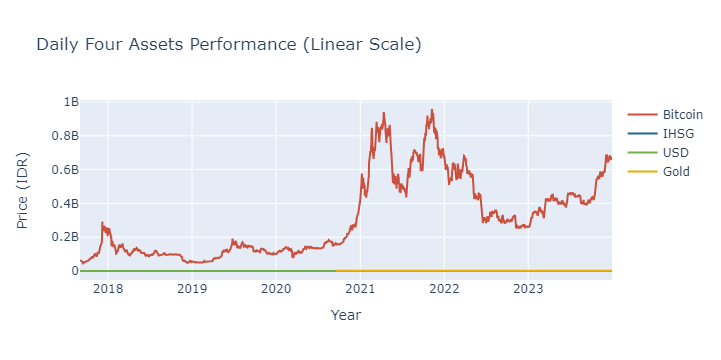

In [213]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=btc_daily['date'],y=btc_daily['closing'],mode='lines',name='Bitcoin',line={'color':color_dict['Bitcoin']}))
fig.add_trace(go.Scatter(x=ihsg_daily['date'],y=ihsg_daily['closing'],mode='lines',name='IHSG',line={'color':color_dict['IHSG']}))
fig.add_trace(go.Scatter(x=usd_daily['date'],y=usd_daily['closing'],mode='lines',name='USD',line={'color':color_dict['USD']}))
fig.add_trace(go.Scatter(x=gold_daily['date'],y=gold_daily['closing'],mode='lines',name='Gold',line={'color':color_dict['Gold']}))

fig.update_xaxes(title='Year')
fig.update_yaxes(title='Price (IDR)')
fig.update_layout(title='Daily Four Assets Performance (Linear Scale)')
fig.show()

As can be seen, Bitcoin prices are significantly higher, resulting in other assets looking non significant, hence we are going to rescale using logarithmic scale.

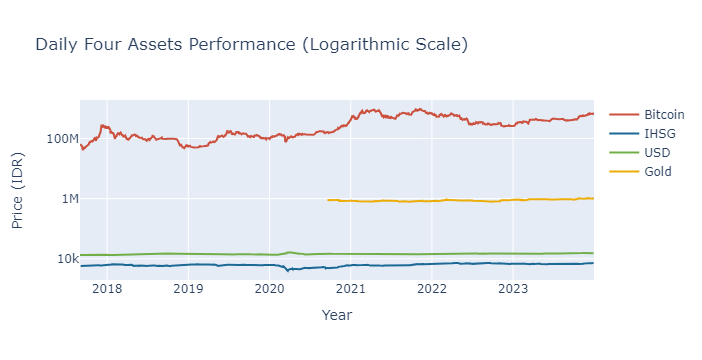

In [214]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=btc_daily['date'],y=btc_daily['closing'],mode='lines',name='Bitcoin',line={'color':color_dict['Bitcoin']}))
fig.add_trace(go.Scatter(x=ihsg_daily['date'],y=ihsg_daily['closing'],mode='lines',name='IHSG',line={'color':color_dict['IHSG']}))
fig.add_trace(go.Scatter(x=usd_daily['date'],y=usd_daily['closing'],mode='lines',name='USD',line={'color':color_dict['USD']}))
fig.add_trace(go.Scatter(x=gold_daily['date'],y=gold_daily['closing'],mode='lines',name='Gold',line={'color':color_dict['Gold']}))

fig.update_yaxes(title='Price (IDR)',type='log')
fig.update_xaxes(title='Year')
fig.update_layout(title='Daily Four Assets Performance (Logarithmic Scale)')
fig.show()

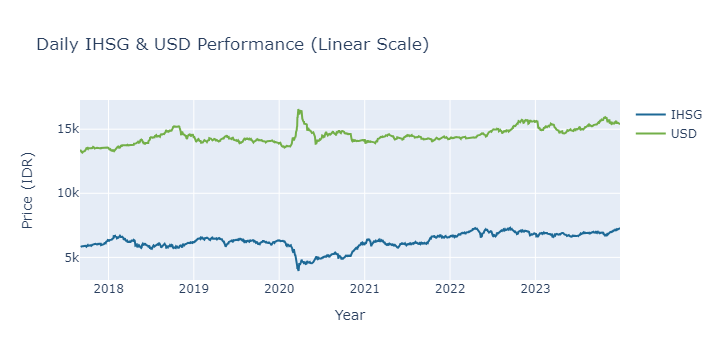

In [215]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=ihsg_daily['date'],y=ihsg_daily['closing'],mode='lines',name='IHSG',line={'color':color_dict['IHSG']}))
fig.add_trace(go.Scatter(x=usd_daily['date'],y=usd_daily['closing'],mode='lines',name='USD',line={'color':color_dict['USD']}))
# fig.add_trace(go.Scatter(x=gold_daily['date'],y=gold_daily['closing'],mode='lines',name='Gold',line={'color':color_dict['Gold']}))

fig.update_xaxes(title='Year')
fig.update_yaxes(title='Price (IDR)')
fig.update_layout(title='Daily IHSG & USD Performance (Linear Scale)')
fig.show()

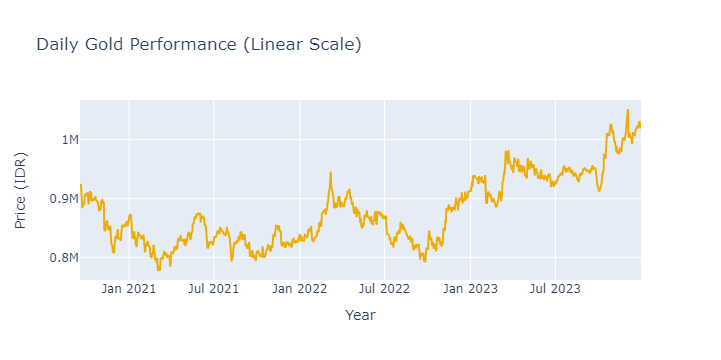

In [216]:
fig = go.Figure()
# fig.add_trace(go.Scatter(x=ihsg_daily['date'],y=ihsg_daily['closing'],mode='lines',name='IHSG',line={'color':color_dict['IHSG']}))
# fig.add_trace(go.Scatter(x=usd_daily['date'],y=usd_daily['closing'],mode='lines',name='USD',line={'color':color_dict['USD']}))
fig.add_trace(go.Scatter(x=gold_daily['date'],y=gold_daily['closing'],mode='lines',name='Gold',line={'color':color_dict['Gold']}))

fig.update_xaxes(title='Year')
fig.update_yaxes(title='Price (IDR)')
fig.update_layout(title='Daily Gold Performance (Linear Scale)')
fig.show()

In [217]:
gold_daily.describe()

closing       opening          high           low
count  1.028000e+03  1.028000e+03  1.028000e+03  1.028000e+03
mean   8.787721e+05  8.784227e+05  8.837762e+05  8.728117e+05
std    5.843118e+04  5.899544e+04  5.860080e+04  5.812825e+04
min    7.772140e+05  5.841490e+05  7.849150e+05  5.841490e+05
25%    8.297915e+05  8.296625e+05  8.346040e+05  8.253245e+05
50%    8.677310e+05  8.677200e+05  8.721630e+05  8.595035e+05
75%    9.287215e+05  9.285412e+05  9.341098e+05  9.213562e+05
max    1.052258e+06  1.050946e+06  1.063628e+06  1.026389e+06

## Correlation Coefficient

In [218]:
combined_monthly.head()

cpi                    btc           usd         ihsg  \
0  109.98     597520998.40000000  14373.052632  7198.951053   
1  100.56  80102200.000000000000  14657.636364  5950.356190   
2   98.11     230653478.70967742  13559.000000  6121.167222   
3  101.54  56513290.322580645161  14204.071429  6450.893000   
4  106.29     853331931.73333333  14523.809524  6012.274286   

                  gold  
0  896046.360000000000  
1                 None  
2                 None  
3                 None  
4  821723.538461538462

In [219]:
cr = combined_monthly.corr(method='pearson')

In [220]:
cr

cpi       btc       usd      ihsg      gold
cpi   1.000000  0.557105  0.751049  0.558019  0.748942
btc   0.557105  1.000000  0.213554  0.408809 -0.284299
usd   0.751049  0.213554  1.000000  0.202723  0.669873
ihsg  0.558019  0.408809  0.202723  1.000000  0.311624
gold  0.748942 -0.284299  0.669873  0.311624  1.000000

In [221]:
cr = combined_monthly.corr(method='pearson')
fig = px.imshow(cr,text_auto='.2f',aspect='auto')

fig.update_layout(title='Correlation Map Between Assets')
fig.update_xaxes(side="top")
fig.show()

## Monthly Changes

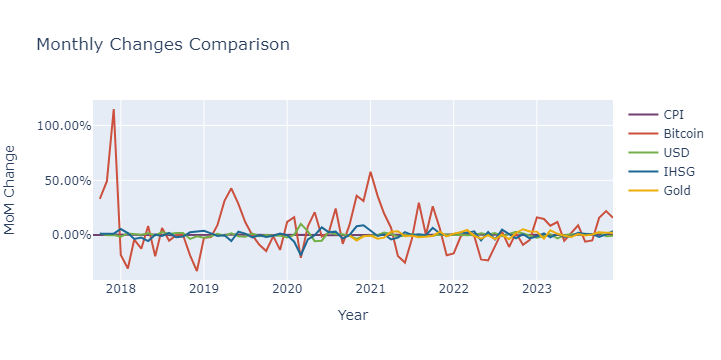

In [222]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=monthly_changes['monthdate'],y=monthly_changes['cpi_mom_change'],mode='lines',name='CPI',line={'color':color_dict['CPI']}))
fig.add_trace(go.Scatter(x=monthly_changes['monthdate'],y=monthly_changes['btc_mom_change'],mode='lines',name='Bitcoin',line={'color':color_dict['Bitcoin']}))
fig.add_trace(go.Scatter(x=monthly_changes['monthdate'],y=monthly_changes['usd_mom_change'],mode='lines',name='USD',line={'color':color_dict['USD']}))
fig.add_trace(go.Scatter(x=monthly_changes['monthdate'],y=monthly_changes['ihsg_mom_change'],mode='lines',name='IHSG',line={'color':color_dict['IHSG']}))
fig.add_trace(go.Scatter(x=monthly_changes['monthdate'],y=monthly_changes['gold_mom_change'],mode='lines',name='Gold',line={'color':color_dict['Gold']}))

fig.update_layout(title='Monthly Changes Comparison')
fig.update_xaxes(title='Year')
fig.update_yaxes(title='MoM Change',tickformat=".2%")
fig.show()

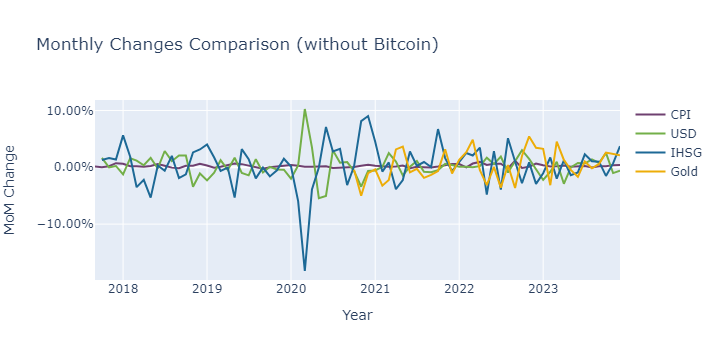

In [223]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=monthly_changes['monthdate'],y=monthly_changes['cpi_mom_change'],mode='lines',name='CPI',line={'color':color_dict['CPI']}))
# fig.add_trace(go.Scatter(x=monthly_changes['monthdate'],y=monthly_changes['btc_mom_change'],mode='lines',name='Bitcoin',line={'color':color_dict['Bitcoin']}))
fig.add_trace(go.Scatter(x=monthly_changes['monthdate'],y=monthly_changes['usd_mom_change'],mode='lines',name='USD',line={'color':color_dict['USD']}))
fig.add_trace(go.Scatter(x=monthly_changes['monthdate'],y=monthly_changes['ihsg_mom_change'],mode='lines',name='IHSG',line={'color':color_dict['IHSG']}))
fig.add_trace(go.Scatter(x=monthly_changes['monthdate'],y=monthly_changes['gold_mom_change'],mode='lines',name='Gold',line={'color':color_dict['Gold']}))

fig.update_layout(title='Monthly Changes Comparison (without Bitcoin)')
fig.update_xaxes(title='Year')
fig.update_yaxes(title='MoM Change',tickformat=".2%")
fig.show()

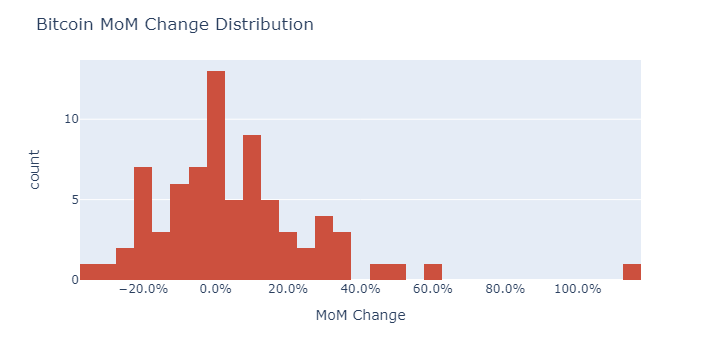

In [224]:
fig = px.histogram(monthly_changes,x='btc_mom_change',nbins=30,color_discrete_sequence=[color_dict['Bitcoin']])

fig.update_layout(title='Bitcoin MoM Change Distribution')
fig.update_xaxes(tickformat=".1%",title='MoM Change')
fig.show()

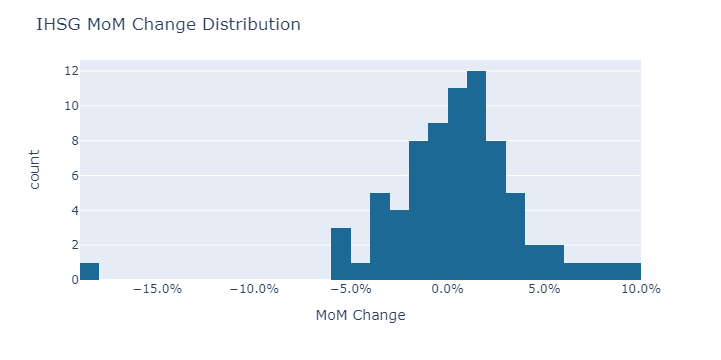

In [225]:
fig = px.histogram(monthly_changes,x='ihsg_mom_change',nbins=30,color_discrete_sequence=[color_dict['IHSG']])

fig.update_layout(title='IHSG MoM Change Distribution')
fig.update_xaxes(tickformat=".1%",title='MoM Change')
fig.show()

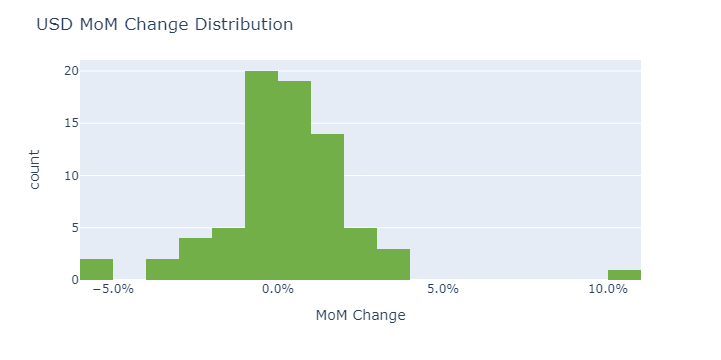

In [226]:
fig = px.histogram(monthly_changes,x='usd_mom_change',nbins=30,color_discrete_sequence=[color_dict['USD']])

fig.update_layout(title='USD MoM Change Distribution')
fig.update_xaxes(tickformat=".1%",title='MoM Change')
fig.show()

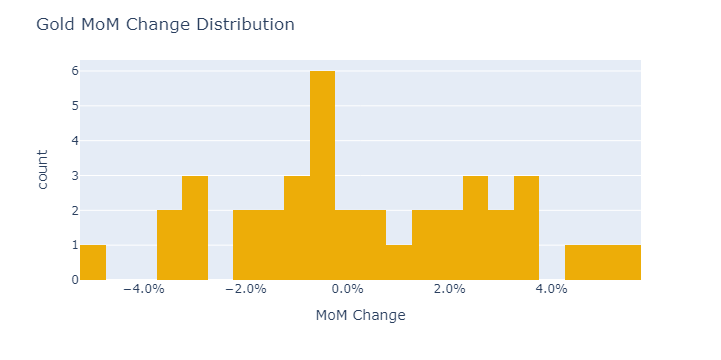

In [227]:
fig = px.histogram(monthly_changes,x='gold_mom_change',nbins=30,color_discrete_sequence=[color_dict['Gold']])

fig.update_layout(title='Gold MoM Change Distribution')
fig.update_xaxes(tickformat=".1%",title='MoM Change')
fig.show()

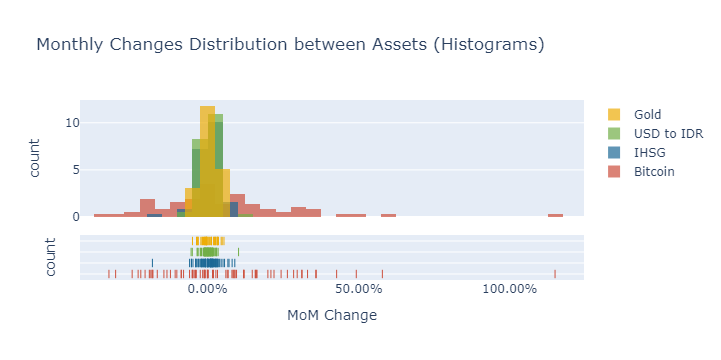

In [228]:
mc_array = [monthly_changes[col].values for col in monthly_changes.columns[2:]]
col_names = ['Bitcoin','IHSG','USD to IDR','Gold']

fig = ff.create_distplot(mc_array,group_labels=col_names,show_curve=False,
                         colors=list(color_dict.values())[1:],bin_size=0.05)

fig.update_layout(title='Monthly Changes Distribution between Assets (Histograms)')
fig.update_xaxes(title='MoM Change',tickformat='.2%')
fig.update_yaxes(title='count',)
fig.show()

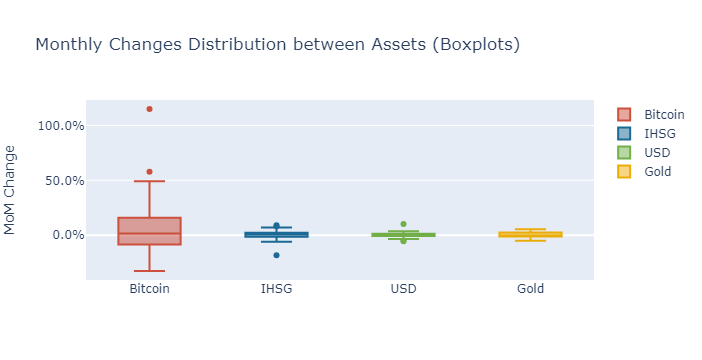

In [229]:
mc = monthly_changes.dropna()
mc_array = [monthly_changes[col].values for col in monthly_changes.columns[2:]]
col_names = ['Bitcoin','IHSG','USD','Gold']

fig = go.Figure()
for val,name in zip(mc_array,col_names):
    fig.add_trace(go.Box(y=val, name=name, marker_color=color_dict[name]))

fig.update_layout(title='Monthly Changes Distribution between Assets (Boxplots)')
fig.update_yaxes(tickformat=".1%",title='MoM Change')

fig.show()

In [252]:
monthly_changes.describe()

cpi_mom_change  btc_mom_change  ihsg_mom_change  usd_mom_change  \
count       76.000000       75.000000        75.000000       75.000000   
mean         0.002413        0.054971         0.003390        0.002239   
std          0.002705        0.226535         0.037352        0.020620   
min         -0.002700       -0.326307        -0.182491       -0.054480   
25%          0.000761       -0.083079        -0.014622       -0.007939   
50%          0.001861        0.016437         0.008549        0.001116   
75%          0.003816        0.158114         0.021806        0.012069   
max          0.011652        1.149788         0.090139        0.102563   

       gold_mom_change  
count        39.000000  
mean          0.003344  
std           0.025953  
min          -0.049957  
25%          -0.012187  
50%          -0.001707  
75%           0.024529  
max           0.054267

## Monthly Changes Correlation

In [230]:
mc = monthly_changes.drop(columns=['monthdate'])
cr = mc.corr(method='pearson')
cr

cpi_mom_change  btc_mom_change  ihsg_mom_change  \
cpi_mom_change         1.000000        0.057680         0.085485   
btc_mom_change         0.057680        1.000000         0.185674   
ihsg_mom_change        0.085485        0.185674         1.000000   
usd_mom_change        -0.127495       -0.135599        -0.645088   
gold_mom_change       -0.059429       -0.140241        -0.193962   

                 usd_mom_change  gold_mom_change  
cpi_mom_change        -0.127495        -0.059429  
btc_mom_change        -0.135599        -0.140241  
ihsg_mom_change       -0.645088        -0.193962  
usd_mom_change         1.000000         0.058566  
gold_mom_change        0.058566         1.000000

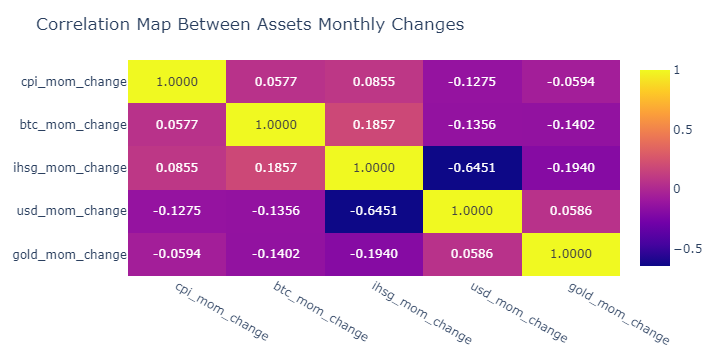

In [231]:
fig = px.imshow(cr,text_auto='.4f',aspect='auto')

fig.update_layout(title='Correlation Map Between Assets Monthly Changes')

## Yearly Changes

In [232]:
yearly_changes.head()

yeardate  cpi_yoy_change  btc_yoy_change  usd_yoy_change  \
0  2016-01-01             NaN             NaN             NaN   
1  2017-01-01        0.038086             NaN             NaN   
2  2018-01-01        0.032002       -0.066710        0.055774   
3  2019-01-01        0.030308       -0.032243       -0.006476   
4  2020-01-01        0.020178        0.531773        0.026331   

   ihsg_yoy_change  gold_yoy_change  
0              NaN              NaN  
1              NaN              NaN  
2         0.016190              NaN  
3         0.034394              NaN  
4        -0.166337              NaN

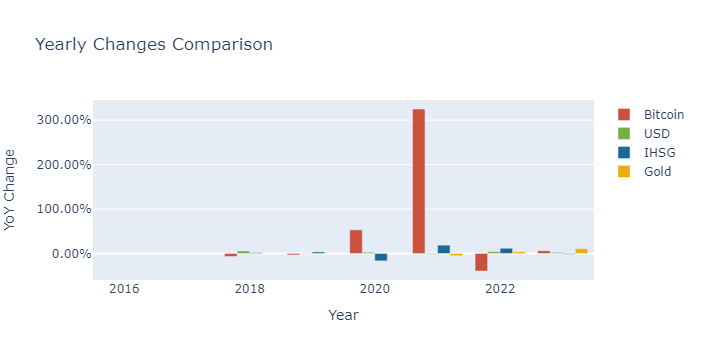

In [254]:
fig = go.Figure()
fig.add_trace(go.Bar(x=yearly_changes['yeardate'],y=yearly_changes['btc_yoy_change'],name='Bitcoin',marker_color=color_dict['Bitcoin']))
fig.add_trace(go.Bar(x=yearly_changes['yeardate'],y=yearly_changes['usd_yoy_change'],name='USD',marker_color=color_dict['USD']))
fig.add_trace(go.Bar(x=yearly_changes['yeardate'],y=yearly_changes['ihsg_yoy_change'],name='IHSG',marker_color=color_dict['IHSG']))
fig.add_trace(go.Bar(x=yearly_changes['yeardate'],y=yearly_changes['gold_yoy_change'],name='Gold',marker_color=color_dict['Gold']))

fig.update_layout(title='Yearly Changes Comparison')
fig.update_yaxes(title='YoY Change', tickformat=".2%")
fig.update_xaxes(title='Year')
fig.show()

# Descriptive Stats

In [234]:
mc.head()

cpi_mom_change  btc_mom_change  ihsg_mom_change  usd_mom_change  \
0        0.001339             NaN              NaN             NaN   
1        0.000103        0.330850         0.012987        0.016551   
2        0.001954        0.492124         0.016285       -0.000018   
3        0.007186        1.149788         0.013747        0.002325   
4        0.006218       -0.180716         0.056185       -0.012655   

   gold_mom_change  
0              NaN  
1              NaN  
2              NaN  
3              NaN  
4              NaN

In [235]:
asset_mc = mc.iloc[:,1:]

In [236]:
asset_mc.describe().round(4)

btc_mom_change  ihsg_mom_change  usd_mom_change  gold_mom_change
count         75.0000          75.0000         75.0000          39.0000
mean           0.0550           0.0034          0.0022           0.0033
std            0.2265           0.0374          0.0206           0.0260
min           -0.3263          -0.1825         -0.0545          -0.0500
25%           -0.0831          -0.0146         -0.0079          -0.0122
50%            0.0164           0.0085          0.0011          -0.0017
75%            0.1581           0.0218          0.0121           0.0245
max            1.1498           0.0901          0.1026           0.0543

In [237]:
summary = pd.DataFrame()
summary['Average Return'] = asset_mc.mean(axis=0)
summary['Volatility'] = asset_mc.std(axis=0)
summary['Sharpe Ratio'] = summary['Average Return']/summary['Volatility']
summary

Average Return  Volatility  Sharpe Ratio
btc_mom_change         0.054971    0.226535      0.242661
ihsg_mom_change        0.003390    0.037352      0.090747
usd_mom_change         0.002239    0.020620      0.108586
gold_mom_change        0.003344    0.025953      0.128865

## Choosing The Right Portfolio

code source: https://www.datacamp.com/workspace/external-link?url=https%3A%2F%2Ftowardsdatascience.com%2Fefficient-frontier-in-python-detailed-tutorial-84a304f03e79

In [245]:
annual_r = (1+asset_mc.mean())**12-1
cov = asset_mc.cov()*12
n_assets = 4

return_variance_pairs = []

weights_list = [] # to store weights
assets_list = [] # to store asset names

for i in range(20000): # simulate 20.000 portfolios
    next_i = False
    while True:
        assets = list(asset_mc.columns)
        weights = np.random.rand(n_assets) # choose weights randomly
        weights = weights/sum(weights)

        # Loop over asset paris and compute portfolio return and variance
        portfolio_exp_variance = 0
        portfolio_exp_return = 0
        for j in range(len(assets)):
            portfolio_exp_return += weights[j] * annual_r.loc[assets[j]]
            for k in range(len(assets)):
                portfolio_exp_variance += weights[j] * weights[k] * cov.loc[assets[j],assets[k]]

        # If a portfolio is suboptimal (we found one with same risk but higher exp return, skip
        for R,V in return_variance_pairs:
            if (R > portfolio_exp_return) & (V < portfolio_exp_variance):
                next_i = True
                break
            if next_i:
                break

        # save mean variance pairs and weights
        return_variance_pairs.append([portfolio_exp_return,portfolio_exp_variance])
        weights_list.append(weights)
        assets_list.append(assets)
        break

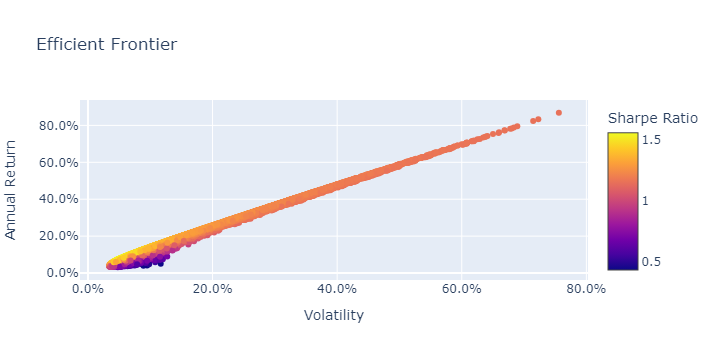

In [246]:
return_variance_pairs = np.array(return_variance_pairs)

fig = go.Figure()
fig.add_trace(go.Scatter(x=return_variance_pairs[:,1]**0.5,y=return_variance_pairs[:,0],mode='markers'
                         ,marker=dict(color=return_variance_pairs[:,0]/(return_variance_pairs[:,1]**0.5)
                          ,showscale=True,colorbar=dict(title='Sharpe Ratio'))))

fig.update_layout(title='Efficient Frontier')
fig.update_xaxes(title='Volatility',tickformat=".1%")
fig.update_yaxes(title='Annual Return',tickformat=".1%")


In [247]:
return_variance_df = pd.DataFrame(return_variance_pairs,columns=['Annual Return','Variance'])
return_variance_df['Sharpe Ratio'] = return_variance_df['Annual Return']/(return_variance_df['Variance']**0.5)
weights_df = pd.DataFrame(weights_list,columns=['Bitcoin','IHSG','USD','Gold'])
combination_df = return_variance_df.join(weights_df)

In [255]:
min_volatility = combination_df.iloc[combination_df['Variance'].idxmin()]
min_volatility.to_frame()

175
Annual Return  0.037230
Variance       0.001157
Sharpe Ratio   1.094669
Bitcoin        0.004642
IHSG           0.239288
USD            0.568406
Gold           0.187665

In [256]:
max_sharpe = combination_df.iloc[combination_df['Sharpe Ratio'].idxmax()]
max_sharpe.to_frame()

19441
Annual Return  0.075212
Variance       0.002345
Sharpe Ratio   1.553292
Bitcoin        0.047681
IHSG           0.239978
USD            0.496722
Gold           0.215619

In [257]:
max_return = combination_df.iloc[combination_df['Annual Return'].idxmax()]
max_return.to_frame()

5183
Annual Return  0.868558
Variance       0.571286
Sharpe Ratio   1.149138
Bitcoin        0.963151
IHSG           0.010892
USD            0.025667
Gold           0.000290

return_variance_pairs = np.array(return_variance_pairs)
annotation_minvol = {'x':min_volatility['Variance']**0.5,'y':min_volatility['Annual Return'],'showarrow':True,'arrowhead':3
                     ,'text':'Minimum Volatility'}
annotation_maxsharpe = {'x':max_sharpe['Variance']**0.5,'y':max_sharpe['Annual Return'],'showarrow':True,'arrowhead':3
                     ,'text':'Max Sharpe Ratio'}
annotation_maxret = {'x':max_return['Variance']**0.5,'y':max_return['Annual Return'],'showarrow':True,'arrowhead':3
                     ,'text':'Max Return'}

fig = go.Figure()
fig.add_trace(go.Scatter(x=return_variance_pairs[:,1]**0.5,y=return_variance_pairs[:,0],mode='markers'
                         ,marker=dict(color=return_variance_pairs[:,0]/(return_variance_pairs[:,1]**0.5)
                          ,showscale=True,colorbar=dict(title='Sharpe Ratio'))))

fig.update_layout(dict(annotations=[annotation_minvol,annotation_maxsharpe,annotation_maxret]),title='Efficient Frontier')
fig.update_xaxes(title='Volatility',tickformat=".1%")
fig.update_yaxes(title='Annual Return',tickformat=".1%")